In [1]:
######################################################################################################
## STEP 1: IMPORTANDO AS BIBLIOTECAS NECESSÁRIAS
######################################################################################################
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components


In [2]:
######################################################################################################
## STEP 2: USANDO HAAR CASCADE PARA DETECTAR CARACTERÍSTICAS FACIAIS
######################################################################################################

# Função que recebe uma imagem colorida como entrada e retorna a mesma imagem convertida para escala de cinza
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Converter a imagem de um espaço de cores RGB para escala de cinza
    return gray

# Função que usará um modelo para detectar o rosto de uma pessoa
def detect_faces(image, face_classifier):
    faces = face_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return faces

# Função que usará um modelo para detectar os olhos de uma pessoa
def detect_eyes(image, eyes_classifier):
    eyes = eyes_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return eyes

# Função que usará um modelo para detectar o nariz de uma pessoa
def detect_noses(image, nose_classifier):
    noses = nose_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return noses

# Função que usará um modelo para detectar a boca de uma pessoa
def detect_mouths(image, mouth_classifier):
    mouths = mouth_classifier.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 50))
    return mouths

# Função que irá nos retornar os contornos de uma imagem
def apply_canny(image):
    edges = cv2.Canny(image, 150, 200)
    return edges

# Função que plotará imagens
def plots(figura, title=''):
    plt.figure(figsize=(20,10))
    plt.imshow(figura, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Função que aleatoriza 
def retirando_pixels(mEdges, thresh):
    lCoord = [] # Lista para armazenar as coordenddas dos pixels de interesse

    for i in range(mEdges.shape[0]):
        for j in range(mEdges.shape[1]):
            if mEdges[i][j] == 255: # Verificando se o ponto encontrado corresponde ao pixel 255
                lCoord.append((i,j)) # Adicionando a coordenada desse pixel encontrado no lCoord
    mainCoord = lCoord.copy() # Copiando a lista de coordenadas dos pontos (coordenadas dos pixels de interesse)
    random.shuffle(lCoord) # Aleatorizando a ordem das coordenadas dos pontos

    times = thresh # Definando um limiar para zerarmos os pixels

    #for i,t in zip(lCoord, range(times)): # Zipamos a lista de coordenadas com o limiar para definirmos um 'critério de parada' no laço
    #        mEdges[i[0]][i[1]] = 0 # Zerando os pixels 255

    return mEdges, mainCoord

# Função que fará o processamento de imagem e nos retornará os contornos das características
def process_image(image_path, face_classifier, eyes_classifier, nose_classifier, mouth_classifier):
    image = cv2.imread(image_path) # Lendo a imagem
    processed_image = preprocess_image(image) # Pré-processando a imagem (convertendo para escala de cinza)
    faces = detect_faces(processed_image, face_classifier) # Detectando o rosto na imagem

    for (x, y, w, h) in faces:
        face_roi = processed_image[y:y+h, x:x+w] # Recortando a região de interesse (Roi) do rosto
        noses = detect_noses(face_roi, nose_classifier) # Detectando o nariz na região de interesse do rosto

        for (nx, ny, nw, nh) in noses:
            nose_roi = face_roi[ny:ny+nh, nx:nx+nw] # Recortando a região de interesse (Roi) do nariz
            plots(nose_roi, title="ROI Nariz") # Plotando a região de interesse do nariz
            nariz_contornos = apply_canny(nose_roi) # Aplicando o detector de bordas de Canny na região de interesse do nariz
            plots(nariz_contornos, title="Contornos com Canny")
            newNoseEdges, mainCoord = retirando_pixels(nariz_contornos, 100)

    return nariz_contornos, mainCoord


In [3]:
######################################################################################################
## STEP 3: CRIANDO MATRIZ DE ADJACENCIAS COM AS LIGAÇÕES ENTRE OS PONTOS PARA MONTAR GRAFOS
######################################################################################################

# Função para processar a matriz e retornar as ligações entre os pontos
def processar_matriz(matriz, limViz1, limViz2):
    def coord_pts(matriz):
        dAuxiliar = {}  # Um dicionário auxiliar para armazenar as coordenadas dos pontos
        pto = 0  # Um contador para contabilizarmos os pontos
        for i in range(matriz.shape[0]):
            for j in range(matriz.shape[1]):
                if matriz[i][j] == 255:  # Verificando se o ponto encontrado corresponde ao pixel 255
                    dAuxiliar[(i, j)] = pto  # Adicionando esse pixel encontrado no dAuxiliar
                    pto += 1
        return dAuxiliar

    def linha_coluna(ponto1, ponto2):
        x1, y1 = ponto1
        x2, y2 = ponto2
        return x1 == x2 or y1 == y2

    def diagonal(ponto1, ponto2):
        x1, y1 = ponto1
        x2, y2 = ponto2
        return abs(x1 - x2) == abs(y1 - y2)

    def distancia_absoluta(ponto1, ponto2):
        distancia_x = abs(ponto1[0] - ponto2[0])
        distancia_y = abs(ponto1[1] - ponto2[1])
        return distancia_x + distancia_y

    def vizinhanca(ponto1, ponto2, limite):
        distancia = distancia_absoluta(ponto1, ponto2)
        return distancia <= limite

    def verificar_vizinhanca(pontos, limViz1, limViz2):
        ligacoes = {}  # Dicionário para armazenar as ligações entre os pontos
        for ponto1, id1 in pontos.items():
            ligacoes[id1] = []  # Inicializa a lista de ligações para o ponto atual
            for ponto2, id2 in pontos.items():
                if ponto1 != ponto2:  # Evitar calcular a distância do ponto com ele mesmo
                    if linha_coluna(ponto1, ponto2):  # Verificando se os pontos estão na mesma linha/coluna
                        if vizinhanca(ponto1, ponto2, limViz1):  # Verificando se as distâncias estão dentro do limite imposto
                            ligacoes[id1].append(id2)  # Adicionar a ligação entre os pontos ao dicionário de ligações

        for ponto1, id1 in pontos.items():
            for ponto2, id2 in pontos.items():
                if ponto1 != ponto2:  # Evitar calcular a distância do ponto com ele mesmo
                    if diagonal(ponto1, ponto2):  # Evitar calcular a distância do ponto com ele mesmo
                        if vizinhanca(ponto1, ponto2, limViz2):  # Verificando se as distâncias estão dentro do limite imposto
                            ligacoes[id1].append(id2)  # Adicionar a ligação entre os pontos ao dicionário de ligações
        return ligacoes

    pontos = coord_pts(matriz)
    resultado = verificar_vizinhanca(pontos, limViz1, limViz2)
    return resultado

# Função para criar a matriz de adjacências
def matriz_adjacencias(graph_dict):
    n = max(graph_dict.keys()) + 1 # Encontra o maior número de nó no grafo e adiciona 1 a ele para ajustar a indexação que começa em 0 no python
    M = np.zeros((n,n)) # Uma matriz de adjacência quadrada n = qtde pixels 255
    
    for node, neighbors in graph_dict.items(): #Itera sobre o dicionário onde cada chave representa um nó e o valor é uma lista de vizinhos desse nó.
        for neighbor in neighbors: # Itera sobre a lista de vizinhos do nó atual.
            M[node][neighbor] = 1 # Define a entrada correspondente na matriz de adjacência como 1 para indicar uma aresta entre o nó node e o vizinho neighbor.
    
    return M


In [4]:
######################################################################################################
## STEP 4: ENCONTRANDO OS PRINCIPAIS COMPONENTES CONECTADOS E OS FILTRANDO
######################################################################################################

# Função para encontrar as principais componentes conectados
def main_connected_components(all_mAdjNose):

    ## Encontrar os componentes conectados na matriz de adjacências
    comp_conectadas, labels = connected_components(all_mAdjNose[0]) # Encontrar os componentes conectados na matriz de adjacências  (comp_conectadas = número de componentes conectados, labels = rótulos dos componentes conectados)

    ## Criando um dicionário para armazenar os rótulos das componentes conectadas e seus respectivos índices
    connectedComponentLabels = {} 

    for i in range(len(labels)): # Iterar sobre os labels e seus respectivos índices
        if labels[i] not in connectedComponentLabels: # Verificar se o label atual já está no dicionário
            connectedComponentLabels[labels[i]] = [i] # Se não estiver, adiciona o índice atual em uma lista
        else:
            connectedComponentLabels[labels[i]].append(i) # Se já estiver, adiciona o índice atual à lista de índices

    print('Dicionário de labels:', connectedComponentLabels)

    ## Dicionário auxiliar para armazenar o número de nó em cada conexo
    componentNodeCount = {}

    for i in connectedComponentLabels.keys(): # Iterar sobre as chaves do dicionário de labels
        componentNodeCount[i] = len(connectedComponentLabels[i]) # Adicionar o número de conectividades em cada conexo ao dicionário auxiliar
    print('Dicionário com a quantidade de nós:',componentNodeCount) 

    ## Encontrar o maior e o menor número de nós em um conexo
    maxNodeComponent = max(componentNodeCount, key=componentNodeCount.get)
    print('Maior nº de nós em um conexo:', componentNodeCount[maxNodeComponent])
    minNodeComponent = min(componentNodeCount, key=componentNodeCount.get) 
    print('Menor nº de nós em um conexo:', componentNodeCount[minNodeComponent])

    # Lista para armazenar as chaves (componentes conexas) que serão deletadas
    componentsToRemove = []

    for key in componentNodeCount.keys(): # Iterar sobre as chaves do dicionário que armazena o número de nós em cada componente
        if componentNodeCount[key] < round(0.2 * componentNodeCount[maxNodeComponent]): # Verificar se o número de nós é menor que 20% do maior número de nós
            componentsToRemove.append(key) # Adicionar a componente à lista de componentes que serão deletadas

    ## Filtrar as componentes conectadas mantendo apenas as principais
    for key in componentsToRemove: # Iterar sobre a lista de componentes que serão deletadas
        del componentNodeCount[key] # Deletar a componente do dicionário componentNodeCount

    listMainComponents = componentNodeCount.keys() # Lista para armazenar as componentes que serão mantidas
    print('Lista das chaves que serão filtradas:', listMainComponents)

    ## Dicionário para armazenar os principais componentes conectados e seus respectivos nós
    dicMainComponents = {}

    for key in listMainComponents: # Iterar sobre as chaves (componentes) que serão mantidas
        dicMainComponents[key] = connectedComponentLabels[key] # Adicionar os nós dos componentes que serão mantidos ao dicionário dos principais componentes conectados

    print('Dicionário com os labels filtrados:', dicMainComponents)
    return dicMainComponents, connectedComponentLabels


In [5]:
######################################################################################################
## STEP 5: DESTACANDO OS PONTOS DAS COMPONENTES CONECTADAS
######################################################################################################

def highlight_components(mainCoord, dicMainComponents):
    '''
    Função para plotar os pontos das componentes conectadas

    - mainCoord: lista de coordenadas dos pontos de interesse
    - dicMainComponents: dicionário com os índices dos pontos filtrados por componente conectada
    '''
    colors = ['blue', 'red', 'green', 'yellow', 'black', 'orange']
    plt.figure(figsize=(8, 6))
    
    for color,label in enumerate(dicMainComponents.keys()): # Iterar sobre as chaves do dicionário que contém os principais componentes conectados
        for idx in dicMainComponents[label]: # Iterar sobre os nós dos componentes conectados
            i, j = mainCoord[idx] # Obter as coordenadas dos pontos
            # print(i, j, idx)
            plt.scatter(j, i, color=colors[color%len(colors)])  # Plotar os pontos filtrados
    
    plt.title("Pontos das Componentes Conectadas")
    plt.xlabel("Coluna")
    plt.ylabel("Linha")
    plt.gca().invert_yaxis()  # Inverter o eixo y para corresponder à orientação das imagens OpenCV
    plt.grid(True)
    plt.show()

def main():
    directory = './image'
    face_classifier = cv2.CascadeClassifier("./models/haarcascade_frontalface_default.xml")
    eyes_classifier = cv2.CascadeClassifier("./models/haarcascade_eye.xml")
    nose_classifier = cv2.CascadeClassifier("./models/haarcascade_mcs_nose.xml")
    mouth_classifier = cv2.CascadeClassifier("./models/haarcascade_mcs_mouth.xml")
    
    all_mAdjNose = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".ppm"):
            image_path = os.path.join(directory, filename)
            mNoseEdges, mainCoord = process_image(image_path, face_classifier, eyes_classifier, nose_classifier, mouth_classifier)
            dLigacoes = processar_matriz(mNoseEdges, limViz1 = 1, limViz2 = 2)
            mAdjNose = matriz_adjacencias(dLigacoes)
            all_mAdjNose.append(mAdjNose)

    return all_mAdjNose, mainCoord, image_path


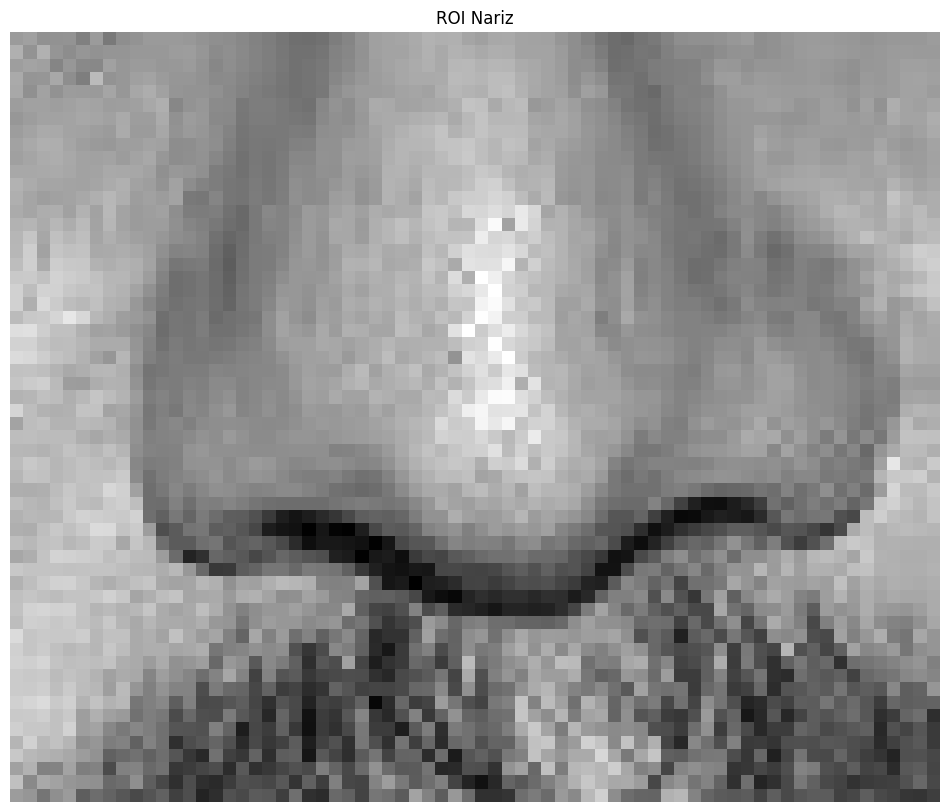

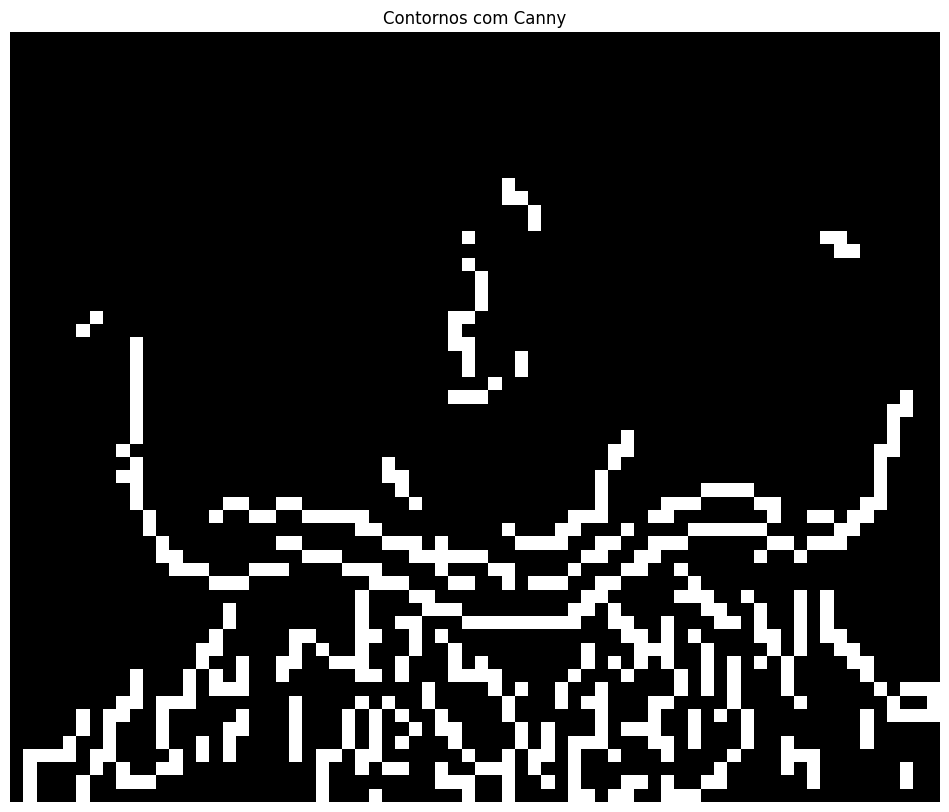

Dicionário de labels: {0: [0, 1, 2, 3, 4], 1: [5], 2: [6, 7, 8, 9], 3: [10, 11, 12, 13, 15, 16, 18, 20, 21, 23, 26], 4: [14, 17], 5: [19, 22, 25, 28, 30, 35, 38, 40, 43, 48, 52, 53, 58, 66, 80, 99, 114, 135, 136, 152, 153, 154, 155, 156, 157, 168, 169, 170], 6: [24, 27], 7: [29, 31, 32, 33], 8: [34, 36, 37, 39, 42, 46, 47, 51, 57, 61, 62, 63, 64, 65, 73, 74, 75, 76, 77, 78, 79, 92, 93, 94, 95, 96, 97, 98, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 127, 128, 129, 130, 131, 132, 133, 134, 137, 138, 139, 148, 149, 150, 151, 158, 159, 160, 165, 166, 171, 172, 173, 180, 181, 183, 184, 185, 186, 187, 195, 196, 197, 198, 199, 200, 201, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 229, 230, 231, 232, 233, 235, 236, 237, 246, 247, 248, 249, 252, 253, 254, 262, 263, 264, 265, 266, 267, 271, 272, 273, 284, 285, 286, 287, 293, 294, 309, 330, 331, 348, 371, 372, 373, 392, 393, 418], 9: [41, 44, 45, 50, 56, 60, 72, 89, 90, 91, 102, 103, 104, 121, 122, 123, 124], 

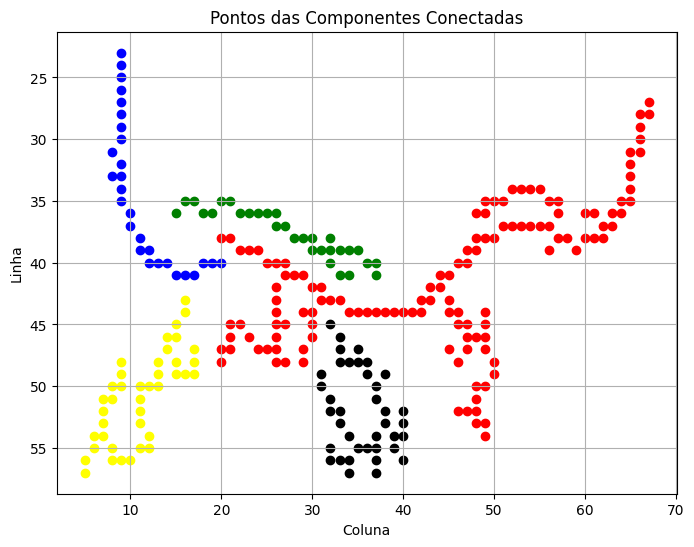

In [6]:

if __name__ == "__main__": 
    all_mAdjNose, mainCoord, image_path = main()
    dicMainComponents, connectedComponentLabels= main_connected_components(all_mAdjNose)
    highlight_components(mainCoord, dicMainComponents)


In [7]:
######################################################################################################
## STEP 6: ENCONTRANDO A ÁRVORE GERADORA MÍNIMA DE UM COMPONENTE CONECTADO
######################################################################################################

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

nodes = connectedComponentLabels[3]

componente_3 = all_mAdjNose[0][np.ix_(nodes,nodes)]
arvore_3 = minimum_spanning_tree(componente_3).toarray().astype(int)
arvore_3 += arvore_3.T
arvore_3

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

In [8]:
nodes

[10, 11, 12, 13, 15, 16, 18, 20, 21, 23, 26]

In [21]:
class No():

    def __init__(self, idx, filhos=None):
        # Inicializa o nó com o índice 'idx' e uma lista de filhos. Se 'filhos' não for passado,
        # uma nova lista vazia é criada para evitar que uma mesma lista seja compartilhada entre instâncias.
        self.idx = idx
        self.filhos = filhos if filhos is not None else []
        


In [22]:
def constroi_arvore(arvore): # Alterando o argumento para 'arvore' (geral) ao invés de usar 'arvore_3' (específico já criado)
    abertos = []  
    n_nos = len(arvore) 
    if n_nos > 0: 
        raiz = No(0) 
        abertos.append(raiz) 

    proximo_no = 0 
    while proximo_no < len(abertos): 
        no = abertos[proximo_no] 
        proximo_no += 1
        for j in range(n_nos): 
            if arvore[no.idx, j] == 1:
                ja_visitou = False 
                for i in range(proximo_no):
                    if abertos[i].idx == j:
                        ja_visitou = True 
                        break
                if not ja_visitou:
                    filho = No(j) 
                    abertos.append(filho)
                    no.filhos.append(filho)
    return raiz          


In [38]:
raiz = constroi_arvore(arvore_3)

In [39]:
# Aceessando a lista de filhos da raiz
raiz.filhos